In [1]:
import sys

COMMON_DIR = "/mnt/d/github/computer_vision/books/generative_deep_learning/pytorch/common"
if COMMON_DIR not in sys.path:
    sys.path.append(COMMON_DIR)

from common.datasets import get_train_loader, get_test_loader
from common.utils import set_seed, plot_images
from common.trainer import fit, evaluate, predict

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.transforms as T

In [3]:
## Data Loading
from common.datasets import CIFAR10

transform = T.Compose([
    T.ToPILImage(),
    T.ToTensor(),
    T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root_dir = "/mnt/d/datasets/cifar10"
train_loader = get_train_loader(dataset=CIFAR10(root_dir, "train", transform=transform), batch_size=128)
test_loader = get_test_loader(dataset=CIFAR10(root_dir, "test", transform=transform), batch_size=64)

batch = next(iter(train_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntrain dataset: {len(train_loader.dataset)}, dataloader: {len(train_loader)}")
print(f"train images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"train labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")

batch = next(iter(test_loader))
images, labels = batch["image"], batch["label"]
print(f"\ntest dataset: {len(test_loader.dataset)}, dataloader: {len(test_loader)}")
print(f"test  images: {images.shape}, {images.dtype}, {images.min()}, {images.max()}")
print(f"test  labels: {labels.shape}, {labels.dtype}, {labels.min()}, {labels.max()}")


train dataset: 50000, dataloader: 390
train images: torch.Size([128, 3, 32, 32]), torch.float32, -1.0, 1.0
train labels: torch.Size([128]), torch.int64, 0, 9

test dataset: 10000, dataloader: 157
test  images: torch.Size([64, 3, 32, 32]), torch.float32, -1.0, 1.0
test  labels: torch.Size([64]), torch.int64, 0, 9


In [4]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Flatten(),
        )

    def forward(self, x):
        x = self.model(x)
        return torch.sigmoid(x)

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, out_channels=3):
        super().__init__()
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, out_channels, 4, 2, 1, bias=False),
        )

    def forward(self, z):
        x = z.view(-1, z.size(1), 1, 1)
        x = self.model(x)
        return torch.tanh(x)
    
    @torch.no_grad()
    def pred_step(self, z):
        latent = batch["image"].to(next(self.parameters()).device)
        images = self.forward(latent)
        return dict(image=images)

In [6]:
def create_images(generator, z_sample):
    device = next(generator.parameters()).device
    z_tensor = torch.tensor(z_sample).float().to(device)
    with torch.no_grad():
        images = generator(z_tensor).cpu().permute(0, 2, 3, 1).numpy()

    images = (images + 1) / 2
    images = np.clip(images, 0, 1)
    return images

In [7]:
from models.gan import GAN

discriminator = Discriminator(in_channels=3)
generator = Generator(latent_dim=100, out_channels=3)
gan = GAN(discriminator, generator)
z_sample = np.random.normal(size=(20, 100))

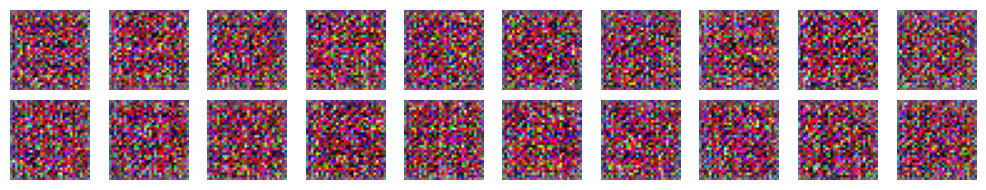

[  1/5] real_loss:0.232, fake_loss:0.200, gen_loss:5.517, real_acc:0.916, fake_acc:0.930, gen_acc:0.002                                                  
[  2/5] real_loss:0.276, fake_loss:0.245, gen_loss:3.913, real_acc:0.898, fake_acc:0.919, gen_acc:0.011                                                  
[  3/5] real_loss:0.289, fake_loss:0.259, gen_loss:3.749, real_acc:0.888, fake_acc:0.903, gen_acc:0.011                                                  
[  4/5] real_loss:0.225, fake_loss:0.206, gen_loss:3.771, real_acc:0.926, fake_acc:0.936, gen_acc:0.009                                                  
[  5/5] real_loss:0.296, fake_loss:0.269, gen_loss:3.574, real_acc:0.898, fake_acc:0.901, gen_acc:0.023                                                  


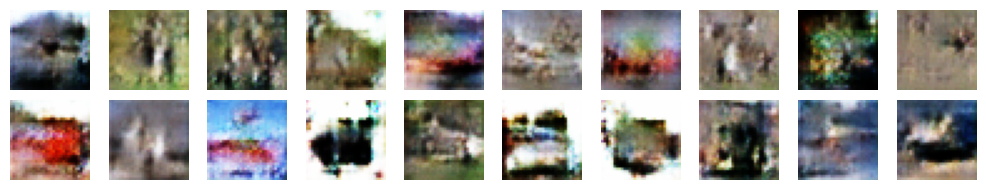

[  1/5] real_loss:0.234, fake_loss:0.229, gen_loss:3.814, real_acc:0.920, fake_acc:0.923, gen_acc:0.016                                                  
[  2/5] real_loss:0.278, fake_loss:0.241, gen_loss:3.591, real_acc:0.904, fake_acc:0.918, gen_acc:0.018                                                  
[  3/5] real_loss:0.205, fake_loss:0.201, gen_loss:4.026, real_acc:0.932, fake_acc:0.934, gen_acc:0.017                                                  
[  4/5] real_loss:0.182, fake_loss:0.173, gen_loss:4.358, real_acc:0.938, fake_acc:0.938, gen_acc:0.012                                                  
[  5/5] real_loss:0.173, fake_loss:0.156, gen_loss:4.504, real_acc:0.945, fake_acc:0.947, gen_acc:0.013                                                  


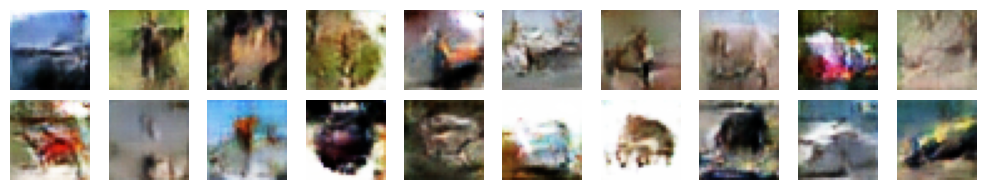

[  1/5] real_loss:0.151, fake_loss:0.133, gen_loss:4.310, real_acc:0.957, fake_acc:0.961, gen_acc:0.009                                                  
[  2/5] real_loss:0.174, fake_loss:0.158, gen_loss:4.243, real_acc:0.946, fake_acc:0.950, gen_acc:0.020                                                  
[  3/5] real_loss:0.143, fake_loss:0.130, gen_loss:4.322, real_acc:0.958, fake_acc:0.962, gen_acc:0.012                                                  
[  4/5] real_loss:0.195, fake_loss:0.181, gen_loss:4.151, real_acc:0.938, fake_acc:0.940, gen_acc:0.025                                                  
[  5/5] real_loss:0.130, fake_loss:0.128, gen_loss:4.344, real_acc:0.963, fake_acc:0.965, gen_acc:0.015                                                  


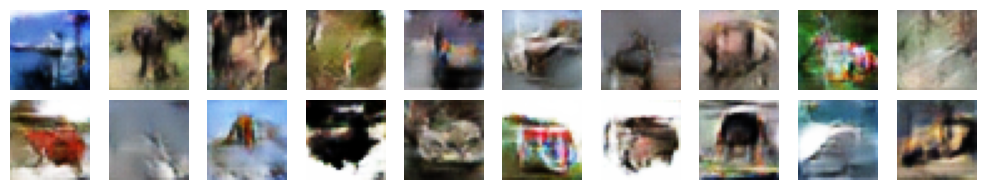

[  1/5] real_loss:0.183, fake_loss:0.181, gen_loss:4.097, real_acc:0.943, fake_acc:0.946, gen_acc:0.023                                                  
[  2/5] real_loss:0.111, fake_loss:0.125, gen_loss:4.310, real_acc:0.967, fake_acc:0.970, gen_acc:0.015                                                  
[  3/5] real_loss:0.160, fake_loss:0.142, gen_loss:4.208, real_acc:0.955, fake_acc:0.958, gen_acc:0.017                                                  
[  4/5] real_loss:0.164, fake_loss:0.146, gen_loss:4.247, real_acc:0.956, fake_acc:0.956, gen_acc:0.020                                                  
[  5/5] real_loss:0.122, fake_loss:0.126, gen_loss:4.372, real_acc:0.971, fake_acc:0.971, gen_acc:0.011                                                  


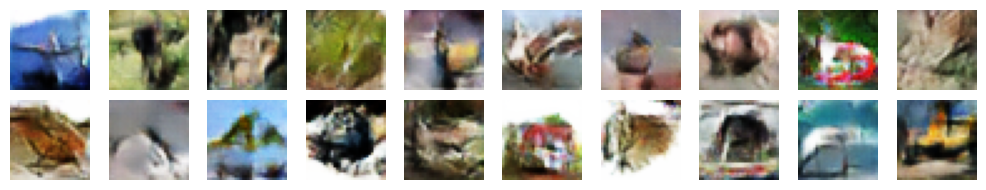

[  1/5] real_loss:0.164, fake_loss:0.165, gen_loss:4.182, real_acc:0.949, fake_acc:0.950, gen_acc:0.025                                                  
[  2/5] real_loss:0.153, fake_loss:0.132, gen_loss:4.067, real_acc:0.967, fake_acc:0.967, gen_acc:0.014                                                  
[  3/5] real_loss:0.149, fake_loss:0.137, gen_loss:4.092, real_acc:0.962, fake_acc:0.963, gen_acc:0.019                                                  
[  4/5] real_loss:0.158, fake_loss:0.182, gen_loss:4.009, real_acc:0.955, fake_acc:0.959, gen_acc:0.022                                                  
[  5/5] real_loss:0.159, fake_loss:0.161, gen_loss:4.002, real_acc:0.955, fake_acc:0.956, gen_acc:0.022                                                  


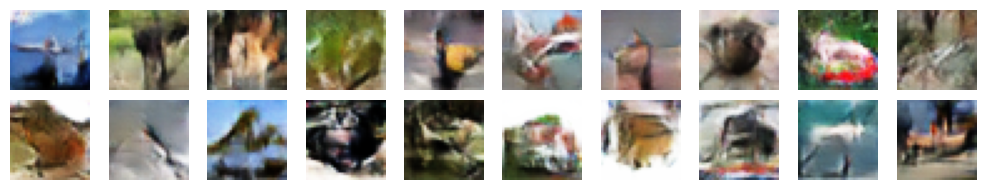

In [8]:
total_history = {}
images = create_images(generator, z_sample)
plot_images(*images, ncols=10, xunit=1, yunit=1)

for _ in range(5):
    history = fit(gan, train_loader, num_epochs=5)
    for split_name, metrics in history.items():
        total_history.setdefault(split_name, {})
        for metric_name, metric_values in metrics.items():
            total_history[split_name].setdefault(metric_name, [])
            total_history[split_name][metric_name].extend(metric_values)

    images = create_images(generator, z_sample)
    plot_images(*images, ncols=10, xunit=1, yunit=1)

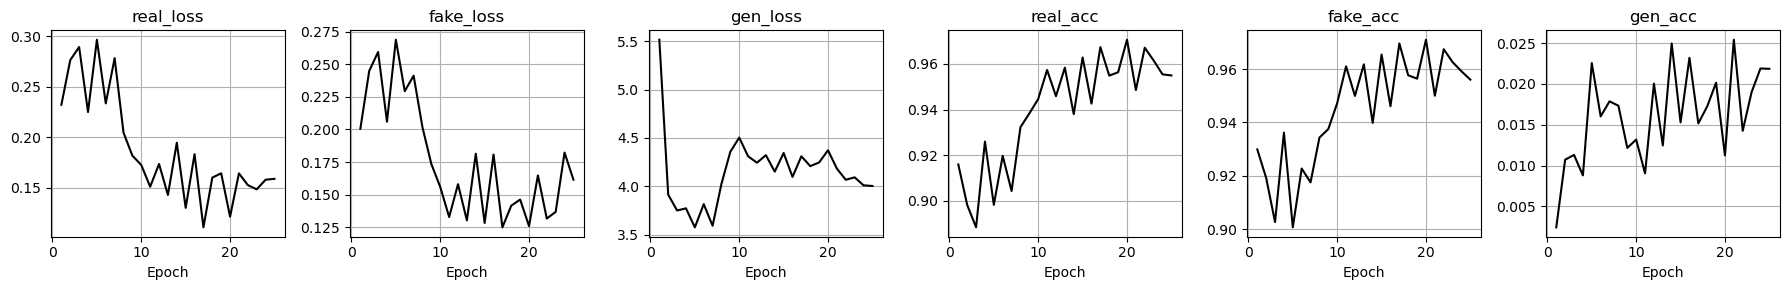

In [9]:
from common.utils import plot_history

plot_history(total_history["train"])